# Monitoring and Debugging

This chapter covers the key details you need to monitor and debug your Spark Applications. To
do this, we will walk through the Spark UI with an example query designed to help you
understand how to trace your own jobs through the execution life cycle. The example we’ll look
at will also help you understand how to debug your jobs and where errors are likely to occur.

## The Monitoring Landscape
At some point, you’ll need to monitor your Spark jobs to understand where issues are occuring in
them. It’s worth reviewing the different things that we can actually monitor and outlining some
of the options for doing so. Let’s review the components we can monitor (see Figure 18-1).
#### Spark Applications and Jobs
The first thing you’ll want to begin monitoring when either debugging or just understanding
better how your application executes against the cluster is the Spark UI and the Spark logs.
These report information about the applications currently running at the level of concepts in
Spark, such as RDDs and query plans. We talk in detail about how to use these Spark
monitoring tools throughout this chapter.
#### JVM
Spark runs the executors in individual Java Virtual Machines (JVMs). Therefore, the next
level of detail would be to monitor the individual virtual machines (VMs) to better
understand how your code is running. JVM utilities such as jstack for providing stack traces,
jmap for creating heap-dumps, jstat for reporting time–series statistics, and jconsole for
visually exploring various JVM properties are useful for those comfortable with JVM
internals. You can also use a tool like jvisualvm to help profile Spark jobs. Some of this
information is provided in the Spark UI, but for very low-level debugging, the
aforementioned tools can come in handy.
#### OS/Machine
The JVMs run on a host operating system (OS) and it’s important to monitor the state of
those machines to ensure that they are healthy. This includes monitoring things like CPU,
network, and I/O. These are often reported in cluster-level monitoring solutions; however,
there are more specific tools that you can use, including dstat, iostat, and iotop.
#### Cluster
Naturally, you can monitor the cluster on which your Spark Application(s) will run. This
might be a YARN, Mesos, or standalone cluster. Usually it’s important to have some sort of
monitoring solution here because, somewhat obviously, if your cluster is not working, you
should probably know pretty quickly. Some popular cluster-level monitoring tools include
Ganglia and Prometheus.
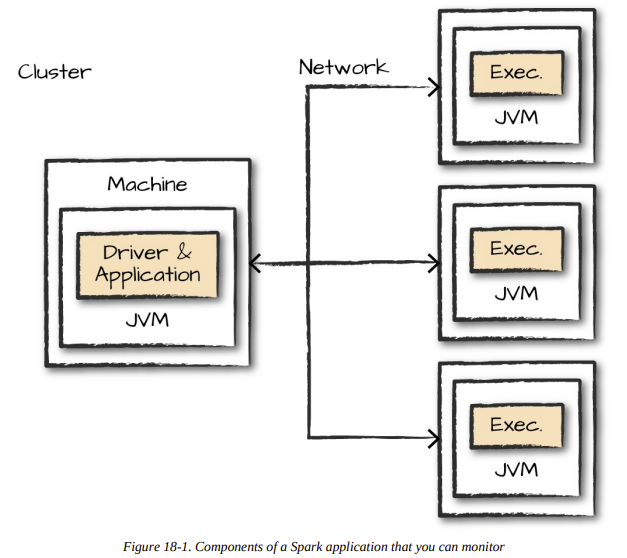

## What to Monitor
After that brief tour of the monitoring landscape, let’s discuss how we can go about monitoring
and debugging our Spark Applications. There are two main things you will want to monitor: the
processes running your application (at the level of CPU usage, memory usage, etc.), and the
query execution inside it (e.g., jobs and tasks).
### Driver and Executor Processes
When you’re monitoring a Spark application, you’re definitely going to want to keep an eye on
the driver. This is where all of the state of your application lives, and you’ll need to be sure it’s
running in a stable manner. If you could monitor only one machine or a single JVM, it would
definitely be the driver. With that being said, understanding the state of the executors is also
extremely important for monitoring individual Spark jobs. To help with this challenge, Spark has
a configurable metrics system based on the Dropwizard Metrics Library. The metrics system is
configured via a configuration file that Spark expects to be present at
$SPARK_HOME/conf/metrics.properties. A custom file location can be specified by changing
the spark.metrics.conf configuration property. These metrics can be output to a variety of
different sinks, including cluster monitoring solutions like Ganglia.
### Queries, Jobs, Stages, and Tasks
Although the driver and executor processes are important to monitor, sometimes you need to
debug what’s going on at the level of a specific query. Spark provides the ability to dive into
queries, jobs, stages, and tasks. (We learned about these in Chapter 15.) This information allows
you to know exactly what’s running on the cluster at a given time. When looking for
performance tuning or debugging, this is where you are most likely to start.
Now that we know what we want to monitor, let’s look at the two most common ways of doing
so: the Spark logs and the Spark UI.

## Spark Logs
One of the most detailed ways to monitor Spark is through its log files. Naturally, strange events
in Spark’s logs, or in the logging that you added to your Spark Application, can help you take
note of exactly where jobs are failing or what is causing that failure. If you use the application
template provided with the book, the logging framework we set up in the template will allow
your application logs to show up along Spark’s own logs, making them very easy to correlate.
One challenge, however, is that Python won’t be able to integrate directly with Spark’s Javabased logging library. Using Python’s logging module or even simple print statements will still
print the results to standard error, however, and make them easy to find.

To change Spark’s log level, simply run the following command:

spark.sparkContext.setLogLevel("INFO")

This will allow you to read the logs, and if you use our application template, you can log your
own relevant information along with these logs, allowing you to inspect both your own
application and Spark. The logs themselves will be printed to standard error when running a local
mode application, or saved to files by your cluster manager when running Spark on a cluster.
Refer to each cluster manager’s documentation about how to find them—typically, they are
available through the cluster manager’s web UI.

You won’t always find the answer you need simply by searching logs, but it can help you
pinpoint the given problem that you’re encountering and possibly add new log statements in your
application to better understand it. It’s also convenient to collect logs over time in order to
reference them in the future. For instance, if your application crashes, you’ll want to debug why,
without access to the now-crashed application. You may also want to ship logs off the machine
they were written on to hold onto them if a machine crashes or gets shut down (e.g., if running in
the cloud).

## The Spark UI
The Spark UI provides a visual way to monitor applications while they are running as well as
metrics about your Spark workload, at the Spark and JVM level. Every SparkContext running
launches a web UI, by default on port 4040, that displays useful information about the
application. When you run Spark in local mode, for example, just navigate to
http://localhost:4040 to see the UI when running a Spark Application on your local machine. If
you’re running multiple applications, they will launch web UIs on increasing port numbers
(4041, 4042, …). Cluster managers will also link to each application’s web UI from their own
UI.
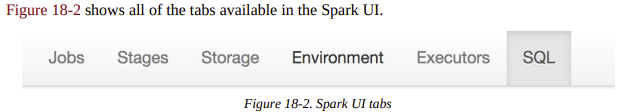
These tabs are accessible for each of the things that we’d like to monitor. For the most part, each
of these should be self-explanatory:
* The Jobs tab refers to Spark jobs.
* The Stages tab pertains to individual stages (and their relevant tasks).
* The Storage tab includes information and the data that is currently cached in our Spark
Application.
* The Environment tab contains relevant information about the configurations and current
settings of the Spark application.
* The SQL tab refers to our Structured API queries (including SQL and DataFrames).
* The Executors tab provides detailed information about each executor running our
application.

Let’s walk through an example of how you can drill down into a given query. Open a new Spark
shell, run the following code, and we will trace its execution through the Spark UI:
~~~
# in Python
spark.read\
  .option("header", "true")\
  .csv("/data/retail-data/all/online-retail-dataset.csv")\
  .repartition(2)\
  .selectExpr("instr(Description, 'GLASS') >= 1 as is_glass")\
  .groupBy("is_glass")\
  .count()\
  .collect()
  ~~~
This results in three rows of various values. The code kicks off a SQL query, so let’s navigate to
the SQL tab, where you should see something similar to Figure 18-3.
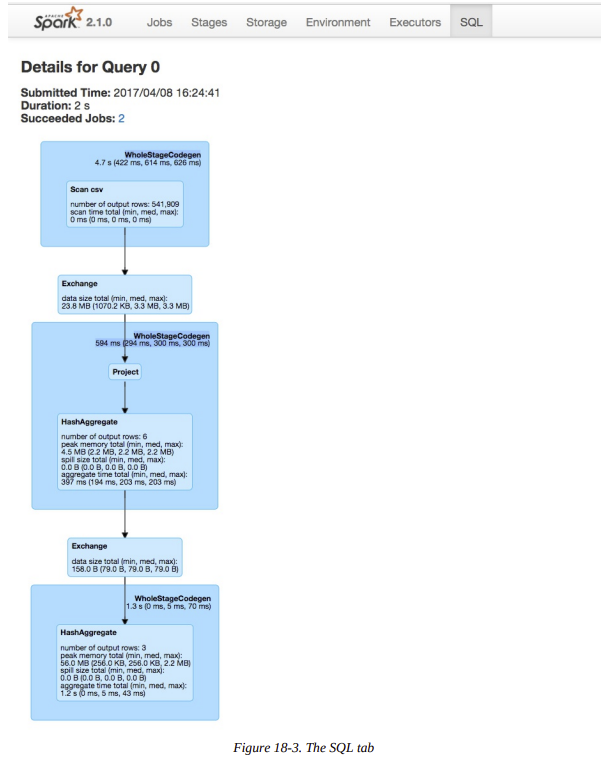
The first thing you see is aggregate statistics about this query:
Submitted Time: 2017/04/08 16:24:41
Duration: 2 s
Succeeded Jobs: 2
These will become important in a minute, but first let’s take a look at the Directed Acyclic Graph
(DAG) of Spark stages. Each blue box in these tabs represent a stage of Spark tasks. The entire
group of these stages represent our Spark job. Let’s take a look at each stage in detail so that we
can better understand what is going on at each level, starting with Figure 18-4.
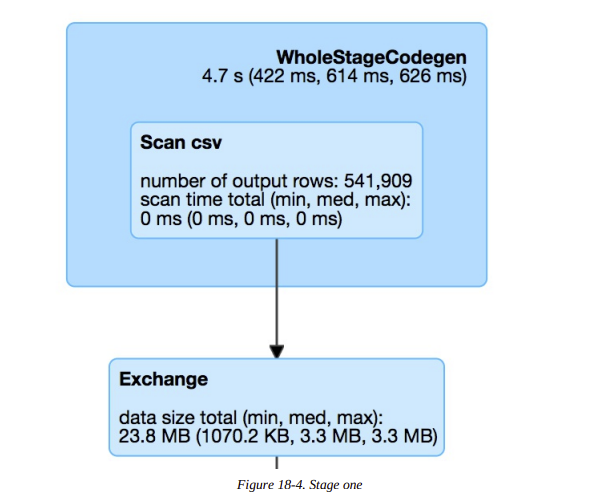
The box on top, labeled WholeStateCodegen, represents a full scan of the CSV file. The box
below that represents a shuffle that we forced when we called repartition. This turned our
original dataset (of a yet to be specified number of partitions) into two partitions.

The next step is our projection (selecting/adding/filtering columns) and the aggregation. Notice
that in Figure 18-5 the number of output rows is six. This convienently lines up with the number
of output rows multiplied by the number of partitions at aggregation time. This is because Spark
performs an aggregation for each partition (in this case a hash-based aggregation) before
shuffling the data around in preparation for the final stage.
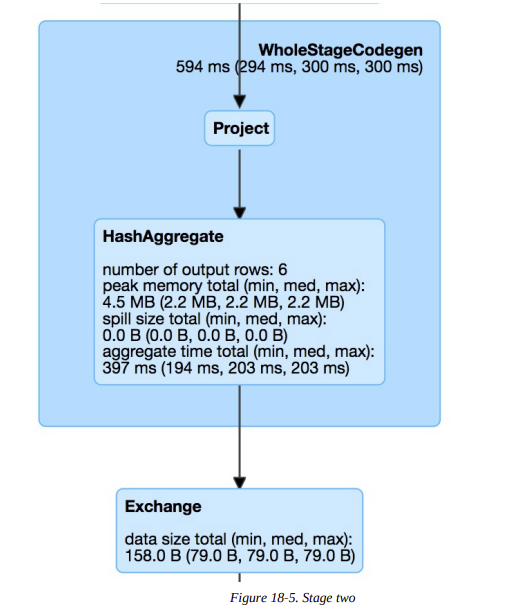
The last stage is the aggregation of the subaggregations that we saw happen on a per-partition
basis in the previous stage. We combine those two partitions in the final three rows that are the
output of our total query (Figure 18-6).
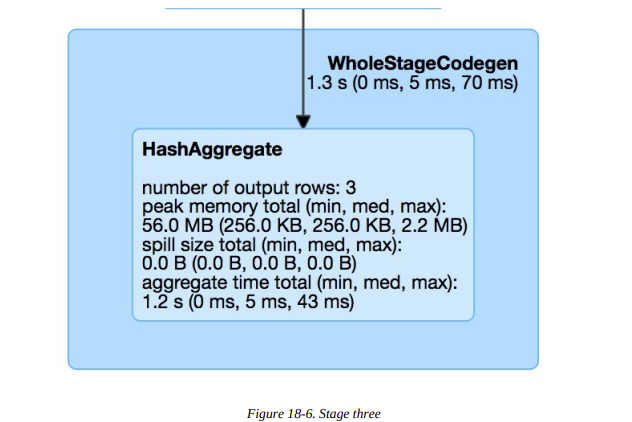
Let’s look further into the job’s execution. On the Jobs tab, next to Succeeded Jobs, click 2. As
Figure 18-7 demonstrates, our job breaks down into three stages (which corresponds to what we
saw on the SQL tab).
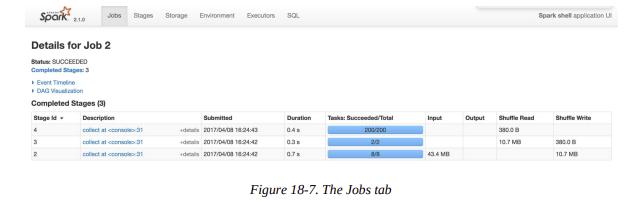
These stages have more or less the same information as what’s shown in Figure 18-6, but
clicking the label for one of them will show the details for a given stage. In this example, three
stages ran, with eight, two, and then two hundred tasks each. Before diving into the stage detail,
let’s review why this is the case.

The first stage has eight tasks. CSV files are splittable, and Spark broke up the work to be
distributed relatively evenly between the different cores on the machine. This happens at the
cluster level and points to an important optimization: how you store your files. The following
stage has two tasks because we explicitly called a repartition to move the data into two partitions.
The last stage has 200 tasks because the default shuffle partitions value is 200.

Now that we reviewed how we got here, click the stage with eight tasks to see the next level of
detail, as shown in Figure 18-8.
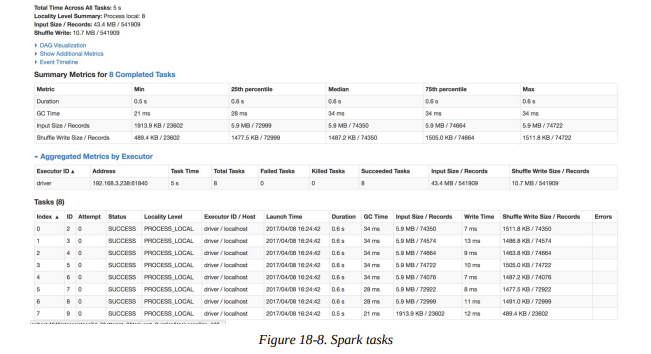
Spark provides a lot of detail about what this job did when it ran. Toward the top, notice the
Summary Metrics section. This provides a synopsis of statistics regarding various metrics. What
you want to be on the lookout for is uneven distributions of the values (we touch on this in
Chapter 19). In this case, everything looks very consistent; there are no wide swings in the
distribution of values. In the table at the bottom, we can also examine on a per-executor basis
(one for every core on this particular machine, in this case). This can help identify whether a
particular executor is struggling with its workload.

Spark also makes available a set of more detailed metrics, as shown in Figure 18-8, which are
probably not relevant to the large majority of users. To view those, click Show Additional
Metrics, and then either choose (De)select All or select individual metrics, depending on what
you want to see.

You can repeat this basic analysis for each stage that you want to analyze. We leave that as an
exercise for the reader.

#### Other Spark UI tabs
The remaining Spark tabs, Storage, Environment, and Executors, are fairly self-explanatory. The
Storage tab shows information about the cached RDDs/DataFrames on the cluster. This can help
you see if certain data has been evicted from the cache over time. The Environment tab shows
you information about the Runtime Environment, including information about Scala and Java as
well as the various Spark Properties that you configured on your cluster.
#### Configuring the Spark user interface
There are a number of configurations that you can set regarding the Spark UI. Many of them are
networking configurations such as enabling access control. Others let you configure how the
Spark UI will behave (e.g., how many jobs, stages, and tasks are stored). Due to space
limitations, we cannot include the entire configuration set here. Consult the relevant table on
Spark UI Configurations in the Spark documentation.

## Spark REST API
In addition to the Spark UI, you can also access Spark’s status and metrics via a REST API. This
is is available at http://localhost:4040/api/v1 and is a way of building visualizations and
monitoring tools on top of Spark itself. For the most part this API exposes the same information
presented in the web UI, except that it doesn’t include any of the SQL-related information. This
can be a useful tool if you would like to build your own reporting solution based on the
information available in the Spark UI. Due to space limitations, we cannot include the list of API
endpoints here. Consult the relevant table on REST API Endpoints in the Spark documentation.
### Spark UI History Server
Normally, the Spark UI is only available while a SparkContext is running, so how can you get to
it after your application crashes or ends? To do this, Spark includes a tool called the Spark
History Server that allows you to reconstruct the Spark UI and REST API, provided that the
application was configured to save an event log. You can find up-to-date information about how
to use this tool in the Spark documentation.

To use the history server, you first need to configure your application to store event logs to a
certain location. You can do this by by enabling spark.eventLog.enabled and the event log
location with the configuration spark.eventLog.dir. Then, once you have stored the events,
you can run the history server as a standalone application, and it will automatically reconstruct
the web UI based on these logs. Some cluster managers and cloud services also configure
logging automatically and run a history server by default.

There are a number of other configurations for the history server. Due to space limitations, we
cannot include the entire configuration set here. Refer to the relevant table on Spark History
Server Configurations in the Spark documentation.

## Debugging and Spark First Aid
The previous sections defined some core “vital signs”—that is, things that we can monitor to
check the health of a Spark Application. For the remainder of the chapter we’re going to take a
“first aid” approach to Spark debugging: We’ll review some signs and symptoms of problems in
your Spark jobs, including signs that you might observe (e.g., slow tasks) as well as symptoms
from Spark itself (e.g., OutOfMemoryError). There are many issues that may affect Spark jobs,
so it’s impossible to cover everything. But we will discuss some of the more common Spark
issues you may encounter. In addition to the signs and symptoms, we’ll also look at some
potential treatments for these issues.

Most of the recommendations about fixing issues refer to the configuration tools discussed in Chapter 16.

### Spark Jobs Not Starting
This issue can arise frequently, especially when you’re just getting started with a fresh
deployment or environment.

Signs and symptoms
* Spark jobs don’t start.
* The Spark UI doesn’t show any nodes on the cluster except the driver.
* The Spark UI seems to be reporting incorrect information.

___Potential treatments___

This mostly occurs when your cluster or your application’s resource demands are not configured
properly. Spark, in a distributed setting, does make some assumptions about networks, file
systems, and other resources. During the process of setting up the cluster, you likely configured
something incorrectly, and now the node that runs the driver cannot talk to the executors. This
might be because you didn’t specify what IP and port is open or didn’t open the correct one. This
is most likely a cluster level, machine, or configuration issue. Another option is that your
application requested more resources per executor than your cluster manager currently has free,
in which case the driver will be waiting forever for executors to be launched.
* Ensure that machines can communicate with one another on the ports that you expect.
Ideally, you should open up all ports between the worker nodes unless you have more
stringent security constraints.
* Ensure that your Spark resource configurations are correct and that your cluster manager
is properly set up for Spark. Try running a simple application first to see if that works.
One common issue may be that you requested more memory per executor than the
cluster manager has free to allocate, so check how much it is reporting free (in its UI)
and your spark-submit memory configuration.

### Errors Before Execution
This can happen when you’re developing a new application and have previously run code on this
cluster, but now some new code won’t work.

Signs and symptoms
* Commands don’t run at all and output large error messages.
* You check the Spark UI and no jobs, stages, or tasks seem to run.

___Potential treatments___

After checking and confirming that the Spark UI environment tab shows the correct information
for your application, it’s worth double-checking your code. Many times, there might be a simple
typo or incorrect column name that is preventing the Spark job from compiling into its
underlying Spark plan (when using the DataFrame API).
* You should take a look at the error returned by Spark to confirm that there isn’t an issue
in your code, such as providing the wrong input file path or field name.
* Double-check to verify that the cluster has the network connectivity that you expect
between your driver, your workers, and the storage system you are using.
* There might be issues with libraries or classpaths that are causing the wrong version of a
library to be loaded for accessing storage. Try simplifying your application until you get
a smaller version that reproduces the issue (e.g., just reading one dataset).

### Errors During Execution
This kind of issue occurs when you already are working on a cluster or parts of your Spark
Application run before you encounter an error. This can be a part of a scheduled job that runs at
some interval or a part of some interactive exploration that seems to fail after some time.

Signs and symptoms

* One Spark job runs successfully on the entire cluster but the next one fails.
* A step in a multistep query fails.
* A scheduled job that ran yesterday is failing today.
* Difficult to parse error message.

___Potential treatments___
* Check to see if your data exists or is in the format that you expect. This can change over
time or some upstream change may have had unintended consequences on your
application.
* If an error quickly pops up when you run a query (i.e., before tasks are launched), it is
most likely an analysis error while planning the query. This means that you likely
misspelled a column name referenced in the query or that a column, view, or table you
referenced does not exist.
* Read through the stack trace to try to find clues about what components are involved
(e.g., what operator and stage it was running in).
* Try to isolate the issue by progressively double-checking input data and ensuring the
data conforms to your expectations. Also try removing logic until you can isolate the
problem in a smaller version of your application.
* If a job runs tasks for some time and then fails, it could be due to a problem with the
input data itself, wherein the schema might be specified incorrectly or a particular row
does not conform to the expected schema. For instance, sometimes your schema might
specify that the data contains no nulls but your data does actually contain nulls, which
can cause certain transformations to fail.
* It’s also possible that your own code for processing the data is crashing, in which case
Spark will show you the exception thrown by your code. In this case, you will see a task
marked as “failed” on the Spark UI, and you can also view the logs on that machine to
understand what it was doing when it failed. Try adding more logs inside your code to
figure out which data record was being processed.

### Slow Tasks or Stragglers
This issue is quite common when optimizing applications, and can occur either due to work not
being evenly distributed across your machines (“skew”), or due to one of your machines being
slower than the others (e.g., due to a hardware problem).

Signs and symptoms

Any of the following are appropriate symptoms of the issue:
* Spark stages seem to execute until there are only a handful of tasks left. Those tasks
then take a long time.
* These slow tasks show up in the Spark UI and occur consistently on the same dataset(s).
* These occur in stages, one after the other.
* Scaling up the number of machines given to the Spark Application doesn’t really help—
some tasks still take much longer than others.
* In the Spark metrics, certain executors are reading and writing much more data than
others.

___Potential treatments___

Slow tasks are often called “stragglers.” There are many reasons they may occur, but most often
the source of this issue is that your data is partitioned unevenly into DataFrame or RDD
partitions. When this happens, some executors might need to work on much larger amounts of
work than others. One particularly common case is that you use a group-by-key operation and
one of the keys just has more data than others. In this case, when you look at the Spark UI, you
might see that the shuffle data for some nodes is much larger than for others.
* Try increasing the number of partitions to have less data per partition.
* Try repartitioning by another combination of columns. For example, stragglers can
come up when you partition by a skewed ID column, or a column where many values
are null. In the latter case, it might make sense to first filter out the null values.
* Try increasing the memory allocated to your executors if possible.
* Monitor the executor that is having trouble and see if it is the same machine across jobs;
you might also have an unhealthy executor or machine in your cluster—for example,
one whose disk is nearly full.
* If this issue is associated with a join or an aggregation, see “Slow Joins” or “Slow
Aggregations”.
* Check whether your user-defined functions (UDFs) are wasteful in their object
allocation or business logic. Try to convert them to DataFrame code if possible.
* Ensure that your UDFs or User-Defined Aggregate Functions (UDAFs) are running on a
small enough batch of data. Oftentimes an aggregation can pull a lot of data into
memory for a common key, leading to that executor having to do a lot more work than
others.
* Turning on speculation, which we discuss in “Slow Reads and Writes”, will have Spark
run a second copy of tasks that are extremely slow. This can be helpful if the issue is
due to a faulty node because the task will get to run on a faster one. Speculation does
come at a cost, however, because it consumes additional resources. In addition, for some
storage systems that use eventual consistency, you could end up with duplicate output
data if your writes are not idempotent. (We discussed speculation configurations in
Chapter 17.)
* Another common issue can arise when you’re working with Datasets. Because Datasets
perform a lot of object instantiation to convert records to Java objects for UDFs, they
can cause a lot of garbage collection. If you’re using Datasets, look at the garbage
collection metrics in the Spark UI to see if they’re consistent with the slow tasks.

Stragglers can be one of the most difficult issues to debug, simply because there are so many
possible causes. However, in all likelihood, the cause will be some kind of data skew, so
definitely begin by checking the Spark UI for imbalanced amounts of data across tasks.

### Slow Aggregations
If you have a slow aggregation, start by reviewing the issues in the “Slow Tasks” section before
proceeding. Having tried those, you might continue to see the same problem.

Signs and symptoms
* Slow tasks during a groupBy call.
* Jobs after the aggregation are slow, as well.

__Potential treatments__

Unfortunately, this issue can’t always be solved. Sometimes, the data in your job just has some
skewed keys, and the operation you want to run on them needs to be slow.
* Increasing the number of partitions, prior to an aggregation, might help by reducing the
number of different keys processed in each task.
* Increasing executor memory can help alleviate this issue, as well. If a single key has lots
of data, this will allow its executor to spill to disk less often and finish faster, although it
may still be much slower than executors processing other keys.
* If you find that tasks after the aggregation are also slow, this means that your dataset
might have remained unbalanced after the aggregation. Try inserting a repartition
call to partition it randomly.
* Ensuring that all filters and SELECT statements that can be are above the aggregation can
help to ensure that you’re working only on the data that you need to be working on and
nothing else. Spark’s query optimizer will automatically do this for the structured APIs.
* Ensure null values are represented correctly (using Spark’s concept of null) and not as
some default value like " " or "EMPTY". Spark often optimizes for skipping nulls early
in the job when possible, but it can’t do so for your own placeholder values.
* Some aggregation functions are also just inherently slower than others. For instance,
collect_list and collect_set are very slow aggregation functions because they
must return all the matching objects to the driver, and should be avoided in
performance-critical code.

### Slow Joins
Joins and aggregations are both shuffles, so they share some of the same general symptoms as
well as treatments.

Signs and symptoms
* A join stage seems to be taking a long time. This can be one task or many tasks.
* Stages before and after the join seem to be operating normally.

__Potential treatments__

* Many joins can be optimized (manually or automatically) to other types of joins. We
covered how to select different join types in Chapter 8.
* Experimenting with different join orderings can really help speed up jobs, especially if
some of those joins filter out a large amount of data; do those first.
* Partitioning a dataset prior to joining can be very helpful for reducing data movement
across the cluster, especially if the same dataset will be used in multiple join operations.
It’s worth experimenting with different prejoin partitioning. Keep in mind, again, that
this isn’t “free” and does come at the cost of a shuffle.
* Slow joins can also be caused by data skew. There’s not always a lot you can do here,
but sizing up the Spark application and/or increasing the size of executors can help, as
described in earlier sections.
* Ensuring that all filters and select statements that can be are above the join can help to
ensure that you’re working only on the data that you need for the join.
* Ensure that null values are handled correctly (that you’re using null) and not some
default value like " " or "EMPTY", as with aggregations.
* Sometimes Spark can’t properly plan for a broadcast join if it doesn’t know any
statistics about the input DataFrame or table. If you know that one of the tables that you
are joining is small, you can try to force a broadcast (as discussed in Chapter 8), or use
Spark’s statistics collection commands to let it analyze the table.

### Slow Reads and Writes
Slow I/O can be difficult to diagnose, especially with networked file systems.

Signs and symptoms
* Slow reading of data from a distributed file system or external system.
* Slow writes from network file systems or blob storage.

__Potential treatments__
* Turning on speculation (set spark.speculation to true) can help with slow reads and
writes. This will launch additional tasks with the same operation in an attempt to see
whether it’s just some transient issue in the first task. Speculation is a powerful tool and
works well with consistent file systems. However, it can cause duplicate data writes
with some eventually consistent cloud services, such as Amazon S3, so check whether it
is supported by the storage system connector you are using.
* Ensuring sufficient network connectivity can be important—your Spark cluster may
simply not have enough total network bandwidth to get to your storage system.
* For distributed file systems such as HDFS running on the same nodes as Spark, make
sure Spark sees the same hostnames for nodes as the file system. This will enable Spark
to do locality-aware scheduling, which you will be able to see in the “locality” column
in the Spark UI. We’ll talk about locality a bit more in the next chapter.

### Driver OutOfMemoryError or Driver Unresponsive
This is usually a pretty serious issue because it will crash your Spark Application. It often
happens due to collecting too much data back to the driver, making it run out of memory.

Signs and symptoms

* Spark Application is unresponsive or crashed.
* OutOfMemoryErrors or garbage collection messages in the driver logs.
* Commands take a very long time to run or don’t run at all.
* Interactivity is very low or non-existent.
* Memory usage is high for the driver JVM.

__Potential treatments__

There are a variety of potential reasons for this happening, and diagnosis is not always
straightforward.
* Your code might have tried to collect an overly large dataset to the driver node using
operations such as collect.
* You might be using a broadcast join where the data to be broadcast is too big. Use
Spark’s maximum broadcast join configuration to better control the size it will
broadcast.
* A long-running application generated a large number of objects on the driver and is
unable to release them. Java’s jmap tool can be useful to see what objects are filling
most of the memory of your driver JVM by printing a histogram of the heap. However,
take note that jmap will pause that JVM while running.
* Increase the driver’s memory allocation if possible to let it work with more data.
* Issues with JVMs running out of memory can happen if you are using another language
binding, such as Python, due to data conversion between the two requiring too much
memory in the JVM. Try to see whether your issue is specific to your chosen language
and bring back less data to the driver node, or write it to a file instead of bringing it back
as in-memory objects.
* If you are sharing a SparkContext with other users (e.g., through the SQL JDBC server
and some notebook environments), ensure that people aren’t trying to do something that
might be causing large amounts of memory allocation in the driver (like working overly
large arrays in their code or collecting large datasets).

### Executor OutOfMemoryError or Executor Unresponsive
Spark applications can sometimes recover from this automatically, depending on the true
underlying issue.

Signs and symptoms
* OutOfMemoryErrors or garbage collection messages in the executor logs. You can find
these in the Spark UI.
* Executors that crash or become unresponsive.
* Slow tasks on certain nodes that never seem to recover.

__Potential treatments__
* Try increasing the memory available to executors and the number of executors.
* Try increasing PySpark worker size via the relevant Python configurations.
* Look for garbage collection error messages in the executor logs. Some of the tasks that
are running, especially if you’re using UDFs, can be creating lots of objects that need to
be garbage collected. Repartition your data to increase parallelism, reduce the amount of
records per task, and ensure that all executors are getting the same amount of work.
* Ensure that null values are handled correctly (that you’re using null) and not some
default value like " " or "EMPTY", as we discussed earlier.
* This is more likely to happen with RDDs or with Datasets because of object
instantiations. Try using fewer UDFs and more of Spark’s structured operations when
possible.
* Use Java monitoring tools such as jmap to get a histogram of heap memory usage on
your executors, and see which classes are taking up the most space.
* If executors are being placed on nodes that also have other workloads running on them,
such as a key-value store, try to isolate your Spark jobs from other jobs.


### Unexpected Nulls in Results
Signs and symptoms
* Unexpected null values after transformations.
* Scheduled production jobs that used to work no longer work, or no longer produce the
right results.

__Potential treatments__
* It’s possible that your data format has changed without adjusting your business logic.
This means that code that worked before is no longer valid.
* Use an accumulator to try to count records or certain types, as well as parsing or
processing errors where you skip a record. This can be helpful because you might think
that you’re parsing data of a certain format, but some of the data doesn’t. Most often,
users will place the accumulator in a UDF when they are parsing their raw data into a
more controlled format and perform the counts there. This allows you to count valid and
invalid records and then operate accordingly after the fact.
* Ensure that your transformations actually result in valid query plans. Spark SQL
sometimes does implicit type coercions that can cause confusing results. For instance,
the SQL expression SELECT 5*"23" results in 115 because the string “25” converts to
an the value 25 as an integer, but the expression SELECT 5 * " " results in null
because casting the empty string to an integer gives null. Make sure that your
intermediate datasets have the schema you expect them to (try using printSchema on
them), and look for any CAST operations in the final query plan.

### No Space Left on Disk Errors
Signs and symptoms
* You see “no space left on disk” errors and your jobs fail.

__Potential treatments__
* The easiest way to alleviate this, of course, is to add more disk space. You can do this
by sizing up the nodes that you’re working on or attaching external storage in a cloud
environment.
* If you have a cluster with limited storage space, some nodes may run out first due to
skew. Repartitioning the data as described earlier may help here.
* There are also a number of storage configurations with which you can experiment.
Some of these determine how long logs should be kept on the machine before being
removed. For more information, see the Spark executor logs rolling configurations in
Chapter 16.
* Try manually removing some old log files or old shuffle files from the machine(s) in
question. This can help alleviate some of the issue although obviously it’s not a
permanent fix.

### Serialization Errors
Signs and symptoms
* You see serialization errors and your jobs fail.

___Potential treatments___
* This is very uncommon when working with the Structured APIs, but you might be
trying to perform some custom logic on executors with UDFs or RDDs and either the
task that you’re trying to serialize to these executors or the data you are trying to share
cannot be serialized. This often happens when you’re working with either some code or
data that cannot be serialized into a UDF or function, or if you’re working with strange
data types that cannot be serialized. If you are using (or intend to be using Kryo
serialization), verify that you’re actually registering your classes so that they are indeed
serialized.
* Try not to refer to any fields of the enclosing object in your UDFs when creating UDFs
inside a Java or Scala class. This can cause Spark to try to serialize the whole enclosing
object, which may not be possible. Instead, copy the relevant fields to local variables in
the same scope as closure and use those.

## Conclusion
This chapter covered some of the main tools that you can use to monitor and debug your Spark
jobs and applications, as well as the most common issues we see and their resolutions. As with
debugging any complex software, we recommend taking a principled, step-by-step approach to
debug issues. Add logging statements to figure out where your job is crashing and what type of
data arrives at each stage, try to isolate the problem to the smallest piece of code possible, and
work up from there. For data skew issues, which are unique to parallel computing, use Spark’s
UI to get a quick overview of how much work each task is doing. In Chapter 19, we discuss
performance tuning in particular and various tools you can use for that.